> Norma Quantum AI Competition Tutorial Source

# Quantum Machine Learning Guide

> 양자 컴퓨팅 프레임워크에 대한 개략적인 소개와 QML의 구현 방법을 제공합니다.

일반적으로 2개의 주요 양자 컴퓨팅 프레임워크가 있습니다:
1. **Pennylane**: 양자 머신러닝에 중점을 둔 프레임워크로, 다양한 양자 하드웨어 백엔드를 지원합니다.
2. **Qiskit**: IBM에서 개발한 프레임워크로, 좀 더 물리적인 실험과 대규모 HPC(High Performance Computing) 연산을 포함하는 통합적인 프레임워크를 제공합니다.

여기에서는 QML 구현을 위해 Pennylane을 사용합니다.

In [ ]:
# 사용할 라이브러리 설치
#!pip install pennylane torch torchvision

## 양자 회로 설계하기

In [1]:
import pennylane as qml
import numpy as np

dev = qml.device("default.qubit", wires=3) # device 정의

@qml.qnode(dev) # QNode 데코레이터로 양자 회로 정의
def circuit():
    qml.H(0)
    qml.S(0)
    qml.RX(0.32, wires=0)
    qml.H(2)
    return qml.probs()

## 양자 회로 그리기

In [2]:
print(qml.draw(circuit)()) # 양자 회로 그리기

0: ──H──S──RX(0.32)─┤  Probs
2: ──H──────────────┤  Probs


(<Figure size 600x300 with 1 Axes>, <Axes: >)

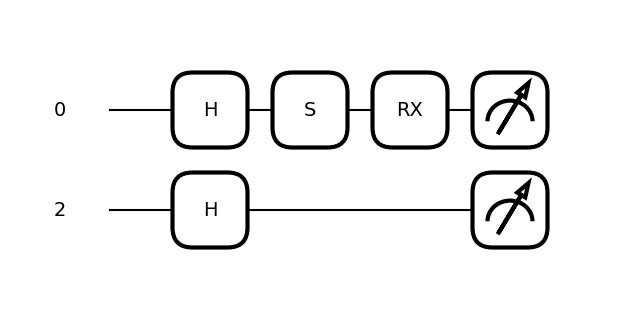

In [3]:
qml.draw_mpl(circuit)()

|양자 회로|ML|
|:---:|:---:|
|Quantum Circuit|Layer, ML Module|
|Backend|device(CPU, CUDA, ...)|

## Backend

Backend는 실제 양자 회로를 구동하는 시뮬레이터, 혹은 양자 컴퓨터입니다.
한 개의 회로를 어느 기기에서 구동할 지 미리 선언을 해주어야 합니다.

**Backend 선택**
다양한 Backend를 양자 회로를 구동하는데 사용할 수 있습니다. Pennylane의 `default.qubit`, `lighting.qubit` 등 뿐만 아니라, Qiskit, IQM 등 실제 양자 컴퓨터의 Backend interface를 가져와 사용할 수도 있습니다.

그러나, QML을 구현하고 시험해 볼 때는 `default.qubit`이 권장됩니다. 다른 ML 프레임워크와의 결합도 간편할 뿐더러 가장 빠른 differentiation 방법을 제공합니다.

In [4]:
NUMBER_OF_WIRES = 20
dev = qml.device("default.qubit", wires=NUMBER_OF_WIRES, shots=3000) # device 정의

## 측정
- `qml.probs` : 개별 state들의 측정 확률 벡터입니다. $N$ qubit에 대해 $2^N$개의 확률을 반환합니다.
- `qml.expval` : Pennylane의 Observable들을 측정합니다. 기초적으로 `qml.PauliZ(i)`, `qml.PauliX(i)`, `qml.PauliY(i)` 등의 Pauli 연산자를 사용합니다. 이 외에도 다양한 Observable를 지원합니다.

In [5]:
dev_3 = qml.device("default.qubit", wires=3) # device 정의

@qml.qnode(dev_3) # QNode 데코레이터로 양자 회로 정의
def circuit1():
    qml.H(0)
    qml.H(1)
    return qml.expval(qml.PauliX(0))

@qml.qnode(dev_3)
def circuit2():
    qml.H(0)
    qml.H(1)
    return qml.probs()

@qml.qnode(dev_3)
def circuit3():
    qml.H(0)
    qml.H(1)
    return [qml.expval(qml.PauliZ(i)) for i in range(3)]


$$<\psi|H|\psi>$$

In [7]:
circuit1()

np.float64(0.9999999999999996)

In [8]:
circuit2()

array([0.25, 0.  , 0.25, 0.  , 0.25, 0.  , 0.25, 0.  ])

In [9]:
circuit3()

[np.float64(0.0), np.float64(0.0), np.float64(0.9999999999999996)]

In [10]:
obs =qml.PauliZ(0) @ qml.PauliX(1)
obs

Z(0) @ X(1)

In [11]:
@qml.qnode(dev_3)
def circuit4():
    qml.H(0)
    qml.H(1)
    qml.H(2)
    return qml.expval(obs)

In [12]:
circuit4()

np.float64(0.0)

## 양자 회로의 설계

In [14]:
from pennylane import numpy as np_p

In [15]:
dev = qml.device("default.qubit", wires=1) # device 정의

@qml.qnode(dev) # QNode 데코레이터로 양자 회로 정의
def single_qubit_circuit(theta, input_value):
    qml.RX(theta, wires=0)
    qml.RY(input_value, wires=0)
    return qml.expval(qml.PauliZ(0))

In [16]:
single_qubit_circuit(0.1, 0.2)

np.float64(0.9751703272018161)

In [19]:
theta = 0.032
theta_b = np_p.array([0.2, 0.3, 0.5])
input_value_b = np_p.array([3.2, 1.2, 0.1])

In [18]:
single_qubit_circuit(theta_b, input_value)

tensor([-0.97839534,  0.34617358,  0.8731983 ], requires_grad=True)

### Pennylane Optimizer

In [20]:
opt = qml.GradientDescentOptimizer(stepsize=0.01)
max_iterations = 500
conv_tol = 1e-06
param = np_p.random.rand(1, requires_grad=True)  # 초기 파라미터 설정

his_param = []
his_energy = []
for i in range(max_iterations):
    param, prev_energy = opt.step_and_cost(lambda x: single_qubit_circuit(x, input_value_b[0]), param)
    his_param.append(param)
    his_energy.append(prev_energy)
    energy = single_qubit_circuit(param, input_value_b[0])
    conv = np_p.abs(prev_energy - energy)
    if conv <= conv_tol:
        break

In [21]:
import matplotlib.pyplot as plt

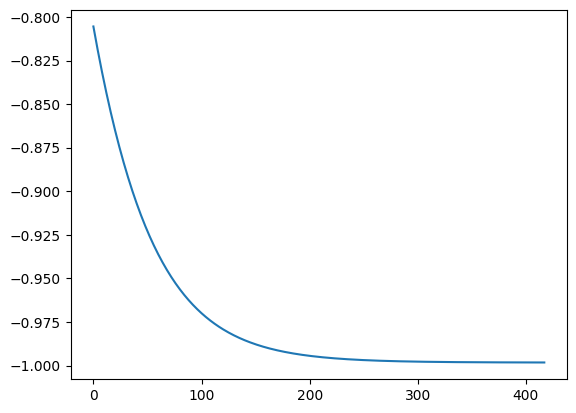

In [22]:
plt.plot(his_energy, label='Energy')

### Torch Optimizer

In [23]:
import torch
from torch.optim import Adam
from torch.nn.parameter import Parameter
from torch.nn import NLLLoss

In [24]:
torch_theta = torch.rand(4)
torch_phi = torch.rand(4)
single_qubit_circuit(torch_theta, torch_phi)

tensor([0.9540, 0.7337, 0.6277, 0.8131], dtype=torch.float64)

In [25]:
parameter = Parameter(torch.tensor(torch.rand(1).item(), requires_grad=True))
parameter

Parameter containing:
tensor(0.9929, requires_grad=True)

In [26]:
optim = Adam([parameter], lr=0.001)

In [27]:
input_data = torch.rand(1)
history_e = []
for i in range(1000):
    optim.zero_grad()
    result = single_qubit_circuit(input_data,parameter)+1
    loss = (result)
    loss.backward()
    history_e.append(result.item())
    optim.step()

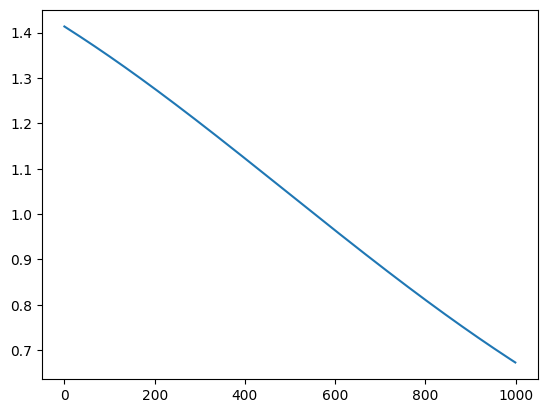

In [28]:
plt.plot(history_e, label='Energy')

## 분류 모델 만들기

### 0-1 binary classfiers

#### MNIST dataset

In [29]:
import torch
from torch.utils.data import Subset, DataLoader
import torchvision

In [30]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = torchvision.datasets.MNIST("./", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST("./", train=False, download=True, transform=transform)

100.0%
100.0%
100.0%
100.0%


In [31]:
t_target = train_dataset.targets
test_target = test_dataset.targets

In [32]:
t_mask = (t_target == 0) | (t_target == 1)
t_indices = torch.where(t_mask)[0]
zero_one_dataset_train = Subset(train_dataset, t_indices)

test_mask = (test_target == 0) | (test_target == 1)
test_indices = torch.where(test_mask)[0]
zero_one_dataset_test = Subset(test_dataset, test_indices)

In [33]:
train_loader = DataLoader(zero_one_dataset_train, batch_size=64, shuffle=True)
test_loader = DataLoader(zero_one_dataset_test, batch_size=64, shuffle=False)

In [34]:
from matplotlib import pyplot as plt

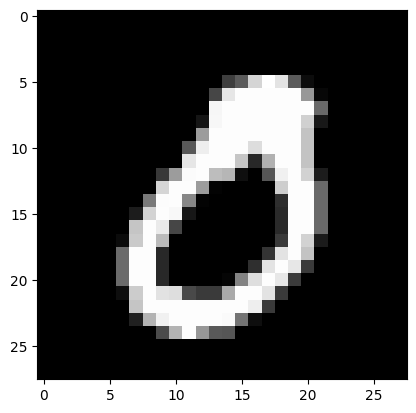

In [35]:
plt.imshow(zero_one_dataset_train[20][0][0], cmap='gray')

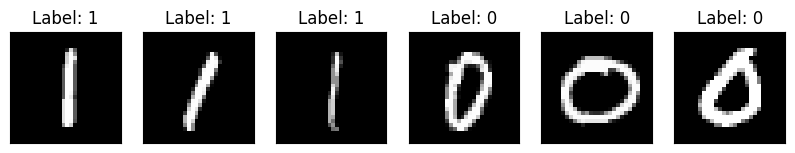

In [36]:
n_samples_show = 6
data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()
    
    axes[n_samples_show - 1].imshow(images[0][0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title(f"Label: {targets[0].item()}")
    
    n_samples_show -= 1

In [37]:
from torch.nn import Module, Conv2d, Dropout2d, Linear
import torch.nn.functional as F
from torch import cat

In [38]:
torch.set_default_dtype(torch.float64)
class BinaryClassifier(Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)
        self.fc3 = Linear(1,1)
        
        # Quantum layer
        self.q_device = qml.device("default.qubit", wires=2)
        self.qnn_params = Parameter(torch.rand(8), requires_grad=True)
        self.obs = qml.PauliZ(0) @ qml.PauliX(1)
        
        @qml.qnode(self.q_device)
        def circuit(x):
            if len(x.shape) == 1:
                x = x.unsqueeze(0)
            qml.H(wires=0)
            qml.H(wires=1)
            
            qml.RZ(2.*x[:,0], wires=0)
            qml.RX(2.*x[:,1], wires=0)
            
            qml.CNOT(wires=[0,1])
            qml.RZ(2.*(torch.pi - x[:,0])*(torch.pi - x[:,1]), wires=1)
            #----
            qml.RY(2.*self.qnn_params[0], wires=0)
            qml.RY(2.*self.qnn_params[1], wires=1)
            qml.CNOT(wires=[0,1])
            qml.RY(2.*self.qnn_params[2], wires=0)
            qml.RY(2.*self.qnn_params[3], wires=1)
            qml.CNOT(wires=[0,1])
            qml.RY(2.*self.qnn_params[4], wires=0)
            qml.RY(2.*self.qnn_params[5], wires=1)
            qml.CNOT(wires=[0,1])
            qml.RY(2.*self.qnn_params[6], wires=0)
            qml.RY(2.*self.qnn_params[7], wires=1)
            return qml.expval(self.obs)

        self.qnn = circuit
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x).unsqueeze(1)
        
        x = self.fc3(x)
        return F.log_softmax(cat((x, 1-x), -1), -1)

In [39]:
torch.tensor([0,1]).shape

torch.Size([2])

In [40]:
bc = BinaryClassifier()

In [44]:
optimizer = Adam(bc.parameters(), lr=0.001)
loss_fn = NLLLoss()

epochs = 20
loss_history = []
bc.train()

BinaryClassifier(
  (conv1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(2, 16, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (fc3): Linear(in_features=1, out_features=1, bias=True)
)

In [45]:
data.shape

torch.Size([64, 1, 28, 28])

In [50]:
from tqdm.auto import tqdm
for epoch in range(epochs):
    total_loss = []
    for bidx, (data, target) in tqdm(enumerate(train_loader)):
        optimizer.zero_grad(set_to_none=True)
        
        output = bc(data)
        loss = loss_fn(output, target.squeeze())
        total_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    loss_history.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss : {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_history[-1]))

/Users/dkmoon/Desktop/StudySpace/QuantumComputing/Source/quantum-ai-competition/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
198it [00:02, 95.11it/s]


Training [5%]	Loss : 0.6996


198it [00:02, 87.64it/s]


Training [10%]	Loss : 0.4585


198it [00:02, 96.02it/s]


Training [15%]	Loss : 0.3130


198it [00:02, 82.74it/s]


Training [20%]	Loss : 0.2251


198it [00:02, 93.83it/s]


Training [25%]	Loss : 0.1705


198it [00:02, 98.37it/s] 


Training [30%]	Loss : 0.1342


198it [00:02, 89.62it/s]


Training [35%]	Loss : 0.1088


198it [00:02, 98.41it/s] 


Training [40%]	Loss : 0.0901


198it [00:02, 84.17it/s]


Training [45%]	Loss : 0.0759


198it [00:02, 92.83it/s]


Training [50%]	Loss : 0.0649


198it [00:02, 77.70it/s]


Training [55%]	Loss : 0.0556


198it [00:02, 90.81it/s]


Training [60%]	Loss : 0.0489


198it [00:02, 93.74it/s]


Training [65%]	Loss : 0.0420


198it [00:02, 94.65it/s]


Training [70%]	Loss : 0.0375


198it [00:01, 99.25it/s] 


Training [75%]	Loss : 0.0329


198it [00:02, 98.10it/s]


Training [80%]	Loss : 0.0299


198it [00:02, 97.68it/s] 


Training [85%]	Loss : 0.0262


198it [00:02, 96.91it/s]


Training [90%]	Loss : 0.0225


198it [00:02, 95.85it/s]


Training [95%]	Loss : 0.0208


198it [00:02, 98.53it/s] 

Training [100%]	Loss : 0.0187


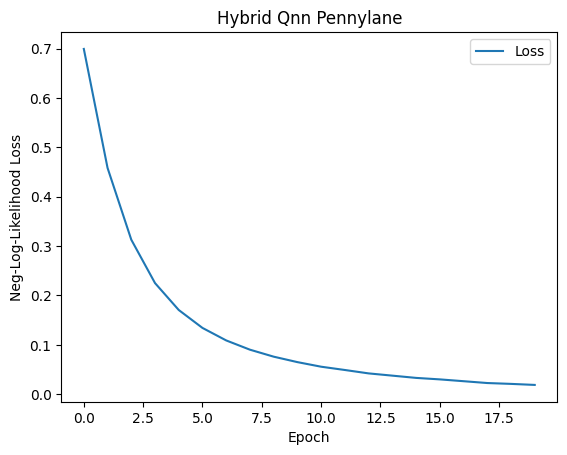

In [51]:
plt.plot(loss_history, label='Loss')
plt.title('Hybrid Qnn Pennylane')
plt.xlabel('Epoch')
plt.ylabel('Neg-Log-Likelihood Loss')
plt.legend()
plt.show()

In [52]:
from torch import save


torch.save(bc.state_dict(), "binary_classifier.pt")

In [53]:
bc2 = BinaryClassifier()
bc2.load_state_dict(torch.load("binary_classifier.pt"))

<All keys matched successfully>

In [54]:
test_loader = DataLoader(zero_one_dataset_test, batch_size=64, shuffle=False)

In [55]:
data, target = next(iter(test_loader))

In [56]:
data.shape

torch.Size([64, 1, 28, 28])

In [58]:
log_softmax_prob = bc2(data)
probs = torch.exp(log_softmax_prob)
prediction = torch.argmax(probs, dim=1,keepdim=True)
prediction.eq(target.view_as(prediction)).sum().item()

64

In [59]:
from torch import no_grad

bc2.eval()
batch_size = 64
with no_grad():
    correct = 0
    total_loss = []
    for batch_idx, (data, target) in enumerate(test_loader):
        log_softmax_prob = bc2(data)
        probs = torch.exp(log_softmax_prob)
        prediction = torch.argmax(probs, dim=1, keepdim=True)
        correct += prediction.eq(target.view_as(prediction)).sum().item()
        
        loss = loss_func(log_softmax_prob, target)
        total_loss.append(loss.item())
    print("Performance on test data:\n\nLoss : {:.4f}\nAccuracy : {:.1f}%".format(sum(total_loss)/len(total_loss), correct / len(test_loader) / batch_size *100))

Performance on test data:

Loss : 0.0168
Accuracy : 97.2%


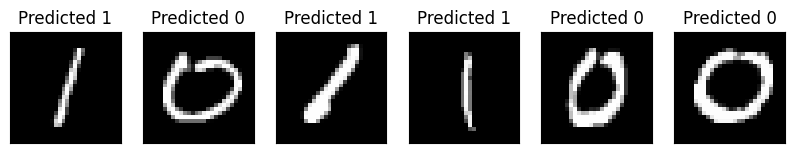

In [60]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

bc2.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count >= n_samples_show:
            break
        
        output = bc2(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
        
        pred = output.argmax(dim=1, keepdim=True)
        
        axes[count].imshow(data[0][0].numpy().squeeze(), cmap='gray')
        
        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(pred.item()))
        
        count += 1